In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

tf.config.run_functions_eagerly(True)

2022-08-31 11:34:58.413007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 11:34:58.413036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# main parameters
qubit_levels = [5, 5]
dim = np.product(qubit_levels)
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -200e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]

In [3]:
# labels for all states
level_labels = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 4 or j > 4:
            level_labels.append(None)
        else:
            level_labels.append(f"{i},{j}")

In [4]:
# find energy eigenvalues and eigenvectors
qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
model = Mdl(qubits, [])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)

# find labels corresponding to states
stateEnergies = []
stateLabels = []
for i, x in enumerate(level_labels):
    #if level_labels[i] is not None:
    energy = evals[i]
    stateEnergies.append(energy)
    stateLabels.append(x)
    print(i, stateLabels[i], stateEnergies[i])

0 0,0 0.0
1 0,1 4500000000.0
2 0,2 8800000000.000002
3 0,3 12899999999.999998
4 0,4 16800000000.0
5 1,0 5000000000.0
6 1,1 9500000000.0
7 1,2 13800000000.000004
8 1,3 17900000000.0
9 1,4 21800000000.0
10 2,0 9700000000.000002
11 2,1 14200000000.000002
12 2,2 18500000000.000004
13 2,3 22600000000.000004
14 2,4 26500000000.0
15 3,0 14099999999.999996
16 3,1 18599999999.999996
17 3,2 22900000000.0
18 3,3 26999999999.999996
19 3,4 30899999999.999996
20 4,0 18199999999.999996
21 4,1 22699999999.999996
22 4,2 26999999999.999996
23 4,3 31099999999.999992
24 4,4 35000000000.0


2022-08-31 11:35:09.040415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-31 11:35:09.040462: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-31 11:35:09.040500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-08-31 11:35:09.040903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# list all transitions
indices = np.argsort(stateEnergies)
sortedEnergies = np.array(stateEnergies)[indices]
sortedLabels = np.array(stateLabels)[indices]
#sortedEnergiesLabels = sorted(zip(stateEnergies, stateLabels), key=lambda x: x[0])
transitionEnergies = []
transitionLabels = []
transitionStateIndices = []
for i in range(len(sortedEnergies)):
    for j in range(i + 1, len(sortedEnergies)):
        E = sortedEnergies[j] - sortedEnergies[i]
        if E > 0:
            transitionEnergies.append(E)
            transitionLabels.append(sortedLabels[i] + " - " + sortedLabels[j])
            transitionStateIndices.append((i, j))

for i in range(len(transitionEnergies)):
    print(i, transitionLabels[i], transitionStateIndices[i], transitionEnergies[i])

0 0,0 - 0,1 (0, 1) 4500000000.0
1 0,0 - 1,0 (0, 2) 5000000000.0
2 0,0 - 0,2 (0, 3) 8800000000.000002
3 0,0 - 1,1 (0, 4) 9500000000.0
4 0,0 - 2,0 (0, 5) 9700000000.000002
5 0,0 - 0,3 (0, 6) 12899999999.999998
6 0,0 - 1,2 (0, 7) 13800000000.000004
7 0,0 - 3,0 (0, 8) 14099999999.999996
8 0,0 - 2,1 (0, 9) 14200000000.000002
9 0,0 - 0,4 (0, 10) 16800000000.0
10 0,0 - 1,3 (0, 11) 17900000000.0
11 0,0 - 4,0 (0, 12) 18199999999.999996
12 0,0 - 2,2 (0, 13) 18500000000.000004
13 0,0 - 3,1 (0, 14) 18599999999.999996
14 0,0 - 1,4 (0, 15) 21800000000.0
15 0,0 - 2,3 (0, 16) 22600000000.000004
16 0,0 - 4,1 (0, 17) 22699999999.999996
17 0,0 - 3,2 (0, 18) 22900000000.0
18 0,0 - 2,4 (0, 19) 26500000000.0
19 0,0 - 3,3 (0, 20) 26999999999.999996
20 0,0 - 4,2 (0, 21) 26999999999.999996
21 0,0 - 3,4 (0, 22) 30899999999.999996
22 0,0 - 4,3 (0, 23) 31099999999.999992
23 0,0 - 4,4 (0, 24) 35000000000.0
24 0,1 - 1,0 (1, 2) 500000000.0
25 0,1 - 0,2 (1, 3) 4300000000.000002
26 0,1 - 1,1 (1, 4) 5000000000.0
27 0,1

In [12]:
# calculate eigenvalues for a range of coupling strengths
def getEnergies(couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                          t2stars, qubit_temps)
    coupling = createChainCouplings([couplingStrength], qubits)

    # Create the model
    model = Mdl(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    # all energy levels with labels
    H = model.get_Hamiltonian().numpy()
    evals,evecs = scipy.linalg.eig(H)
    return evals.real / (2 * np.pi)

couplings = np.linspace(15e6, 25e6, 100)
allEnergies = np.empty(shape=(dim,0))
for coupling in couplings:
    #print(coupling)
    energies = getEnergies(coupling)
    energies = np.sort(energies)
    allEnergies = np.append(allEnergies, np.reshape(energies, (dim,1)), axis=1)

In [13]:
w1, w2 = qubit_frequencies
l1, l2 = anharmonicities
delta = w1 - w2
w = w1 + w2

analyticalEnergies = np.empty(shape=(16,len(couplings)))
for state in np.arange(16):
    n1 = state // 4
    n2 = state % 4
    E0 = (n1 * w1 + n2 * w2)
    E1 = 0.5 * (l1 * n1 * (n1 - 1) + l2 * n2 * (n2 - 1))
    E2 = 0
    A = (delta + l1 * (n1 - 1) - l2 * n2)
    E2 += n1 * (n2 + 1) / A if A != 0 else 0
    B = delta + l1 * n1 - l2 * (n2 - 1)
    E2 -= n2 * (n1 + 1) / B if B != 0 else 0
    C = w + l1 * (n1 - 1) + l2 * (n2 - 1)
    E2 += n1 * n1 / C if C != 0 else 0
    D = w + l1 * n1 + l2 * n2
    E2 -= (n1 + 1) * (n2 + 1) / D if D != 0 else 0
    print(state, n1, n2)
    #E2 = (couplings ** 2 / delta) * (n1 - n2) - (couplings ** 2 / w) * (n1 + n2 + 1)
    #E3 = -(couplings ** 2 / delta ** 2) * (n1 - n2) * (l1 * n1 * (n1 - 1) + l2 * n2 * (n2 - 1))
    E2 *= couplings ** 2
    print(state, E0, E1, E2[-1])
    analyticalEnergies[state] = (E0 + E1) * np.ones_like(couplings) + E2

0 0 0
0 0.0 0.0 -65789.47368421052
1 0 1
1 4500000000.0 0.0 -1384408.6021505378
2 0 2
2 9000000000.0 -200000000.0 -1991758.2417582418
3 0 3
3 13500000000.0 -600000000.0 -2364232.209737828
4 1 0
4 5000000000.0 0.0 1178563.4244733304
5 1 1
5 9500000000.0 -0.0 -4676274.018379282
6 1 2
6 14000000000.0 -200000000.0 -4525598.729227762
7 1 3
7 18500000000.0 -600000000.0 -4489986.757428618
8 2 0
8 10000000000.0 -300000000.0 6305283.28950514
9 2 1
9 14500000000.0 -300000000.0 24840704.64767616
10 2 2
10 19000000000.0 -500000000.0 -31633986.928104576
11 2 3
11 23500000000.0 -900000000.0 -13119523.548740415
12 3 0
12 15000000000.0 -900000000.0 -18422565.806286734
13 3 1
13 19500000000.0 -900000000.0 43786784.37667202
14 3 2
14 24000000000.0 -1100000000.0 43481917.57779646
15 3 3
15 28500000000.0 -1500000000.0 14411764.705882352


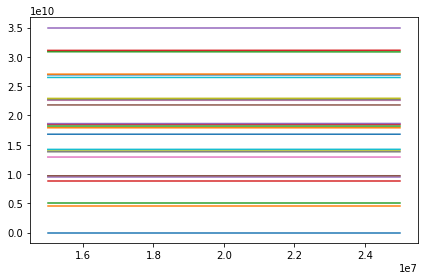

In [14]:
# Energy level diagram
plt.figure()
#y = allEnergies[[11, 12]].T
y = allEnergies.T
plt.plot(couplings, y)
#for i in [10, 13]:
#    plt.plot(couplings[::5], analyticalEnergies[i][::5], 'o')
#plt.plot(couplings, analyticalEnergies[0], '--')
#plt.legend(sortedLabels, ncol=1, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
#plt.savefig('energies-couplings.svg')
plt.show()

147 (7, 8) 1,2 - 3,0 295324505.42453766
209 (11, 12) 1,3 - 4,0 299304907.2960701
222 (12, 13) 4,0 - 2,2 292443455.52876663


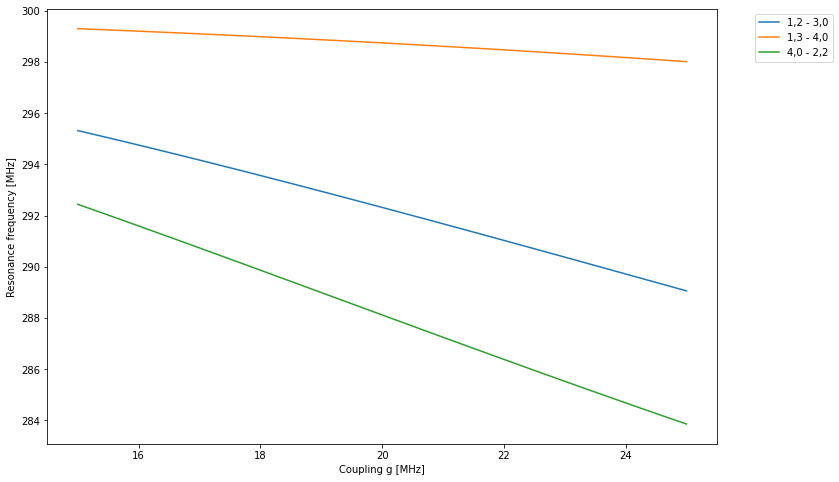

In [22]:
# Transition diagram
#selectedTransitions = [1, 26, 72, 133] #[1, 26, 49, 94, 112, 184] #[67, 101]#1, 17, 31, 58
selectedTransitions = list(range(len(transitionStateIndices)))
#selectedTransitions = [110]

plt.figure(figsize=(12,8))
for t in selectedTransitions:
    index = transitionStateIndices[t]
    data1 = allEnergies[index[0]]
    data2 = allEnergies[index[1]]
    diff = data2 - data1
    if 0.28e9 < diff[0] < 0.31e9:
        print(t, index, transitionLabels[t], diff[0])
        plt.plot(couplings / 1e6, diff / 1e6, label=transitionLabels[t])
#plt.plot(couplings, analyticalEnergies[4] - analyticalEnergies[1], 'x')
plt.xlabel("Coupling g [MHz]")
plt.ylabel("Resonance frequency [MHz]")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()